In [1]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

In [2]:
def absolute_path_joiner(img_path: str):
    new_path = os.path.join(os.getcwd(), img_path)
    return new_path

In [19]:
SAMPLE_IMAGE_DIR = "../../../resources/need_annotating/OLOMBENDO/"
random.seed(42)
sample_images = random.choices(os.listdir(SAMPLE_IMAGE_DIR), k=10)
sample_image_paths = [
    os.path.join(SAMPLE_IMAGE_DIR, img) for img in sample_images
]
sample_image_paths = [absolute_path_joiner(img) for img in sample_image_paths]
flags = []
imgs = [
    cv.imread(img_path, cv.IMREAD_GRAYSCALE) for img_path in sample_image_paths
]
imgs_blurred = [cv.GaussianBlur(img, (5, 5), 0) for img in imgs]
imgs_binary = [
    cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    for idx, img in enumerate(imgs_blurred)
]

gray_cmap = plt.get_cmap("gray")

In [150]:
from preprocess import find_significant_inner_boundary

In [149]:
def _find_contours(
    img,
    min_thresh=127,
    max_thresh=255,
    mode=cv.RETR_TREE,
    method=cv.CHAIN_APPROX_SIMPLE,
):
    """
    Takes a MatLike object and returns contours. This function handles the
    binarization of the image as well as the contour finding.
    """
    ret, thresh = cv.threshold(img, min_thresh, max_thresh, 0)
    all_contours, hierarchy = cv.findContours(thresh, mode, method)

    return all_contours

In [151]:
def _draw_bbox_on_image(img, bbox, color=(0, 255, 0), thickness=2):
    """
    Draws a bounding box on the image and displays it.
    """
    x, y, w, h = bbox
    cv.rectangle(img, (x, y), (x + w, y + h), color, thickness)

    # Display the image with the bounding box
    plt.imshow(img, cmap=gray_cmap)
    plt.axis("off")
    plt.show()

    return img


In [157]:
def _figure_extraction(img, **kwargs):
    """
    Takes a MatLike object and returns the bbox of the figure translated to
    the original image coordinate system.

    Args:
        img (MatLike): The image to process.
        **kwargs: Additional arguments for contour finding.
            - min_area_ratio (float): Minimum area ratio for contour filtering.
            - edge_margin_ratio (float): Edge margin ratio for contour filtering.
            - area_drop_off_ratio (float): Area drop-off ratio for contour filtering.
            - show_bbox (bool): Whether to display the bounding box on the image.

    Returns:
        tuple: The bounding box of the figure in the format (x, y, w, h).
    """
    contours = _find_contours(img)

    contour_candidates = find_significant_inner_boundary(
        all_contours=contours,
        img=img,
        min_area_ratio=kwargs.get("min_area_ratio", 0.01),      # 1% min area
        edge_margin_ratio=kwargs.get("edge_margin_ratio", 0.005),  # 0.1% edge margin
        area_drop_off_ratio=kwargs.get("area_drop_off_ratio", 1.75),  # Drop-off if area ratio > 1.75
    )

    best_candidate = contour_candidates[0]
    figure_bbox = cv.boundingRect(best_candidate)

    if kwargs.get("show_bbox", False):
        _draw_bbox_on_image(img, figure_bbox)

    return figure_bbox

In [187]:
def _table_extraction(img, figure_bbox, **kwargs):
    """
    Takes a MatLike object and returns the bbox of the table translated to
    the original image coordinate system.

    Args:
        img (MatLike): The image to process.
        figure_bbox (tuple | list): The bounding box of the figure.
        **kwargs: Additional arguments for contour finding.
            - show_bbox (bool): Whether to show the bounding box on the image.

    Returns:
        tuple: The bounding box of the table in the format (x, y, w, h).
    """
    # Crop original image everything to the right of the figure bbox
    # and trim the top and bottom of the image to the figure bbox
    fx, fy, fw, fh = figure_bbox

    print(img.shape)
    ih, iw = img.shape

    table_bbox = fx + fw, fy, iw, fh
    print(table_bbox)

    if kwargs.get("show_bbox", False):
        _draw_bbox_on_image(img, table_bbox)

    return table_bbox

In [159]:
def figure_table_extraction(img_path: str, **kwargs):
    """
    Takes an image path and returns the cropped figure and table images.

    Args:
        img_path (str): Path to the image file.
    """
    # load image
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

    # figure extraction
    try:
        figure_kwargs = kwargs.get("figure_kwargs", {})
        figure_bbox = _figure_extraction(img, kwargs=figure_kwargs)
    except Exception as e:
        print(f"Error during figure extraction: {e}")
        return None, None

    # table extraction
    try:
        table_kwargs = kwargs.get("table_kwargs", {})
        table_bbox = _table_extraction(img, figure_bbox, kwargs=table_kwargs)
    except Exception as e:
        print(f"Error during table extraction: {e}")
        return None, None


    # crop image
    fx, fy, fw, fh = figure_bbox
    tx, ty, tw, th = table_bbox

    figure_crop = img[fy : fy + fh, fx : fx + fw]
    table_crop = img[ty : ty + th, tx : tx + tw]

    return figure_crop, table_crop

In [188]:
fc, tc = figure_table_extraction(img_path=sample_image_paths[0], figure_kwargs={"show_bbox": True}, table_kwargs={"show_bbox": True})

(3392, 4768)
(3876, 114, 4768, 3142)


Original image is grayscale, converting to BGR for processing and drawing.

=== STEP 1: Finding Figure Contour ===
Figure contour found.
Figure BBox (x,y,w,h): 116, 114, 3760, 3142

=== STEP 2: Finding Table Contour ===
Table slice image shape: (3392, 987)
Table contour found in slice.

=== STEP 3: Visualizing Results ===
[array([[[3878, 1064]],

       [[3878, 1586]],

       [[4609, 1586]],

       [[4610, 1585]],

       [[4610, 1456]],

       [[4609, 1455]],

       [[4610, 1454]],

       [[4610, 1182]],

       [[4609, 1181]],

       [[4610, 1180]],

       [[4610, 1065]],

       [[4609, 1064]]], dtype=int32)]


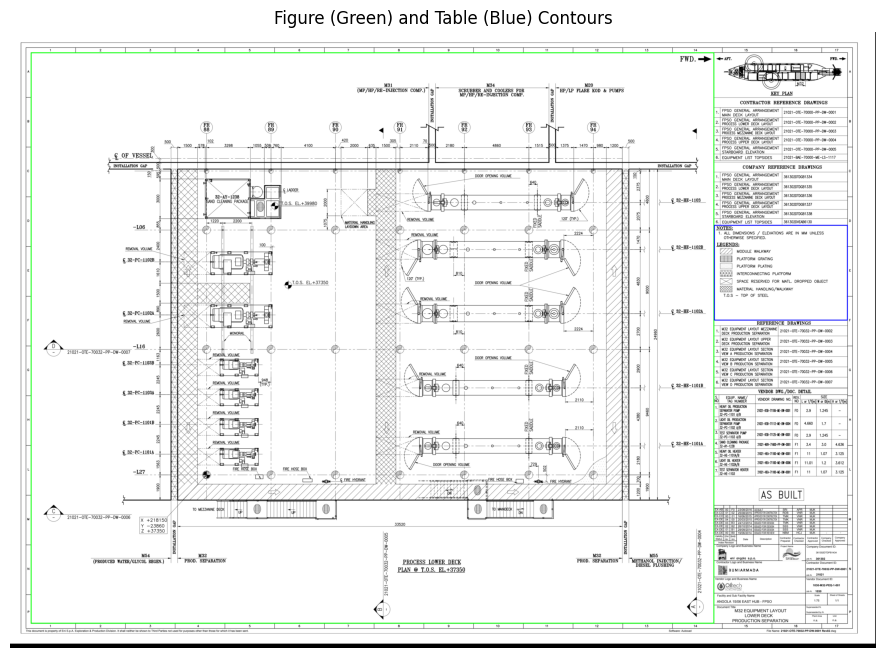

In [ ]:
def run_figure_and_table_extraction_workflow(img_no: int):
    """
    Main workflow to find figure and table contours.
    """
    # 3. Prepare for Table Contour Extraction
    print("\n=== STEP 2: Finding Table Contour ===")
    # Create a slice of the original image to the right of the figure's bounding box
    # The table is connected to the figure via the right edge of the figure contour

    # Define a small gap or overlap if necessary, or use figure_bbox directly
    # For this example, let's assume the table starts immediately to the right
    table_slice_start_x = figure_bbox[0] + figure_bbox[2]

    # Ensure the slice is within image bounds
    if table_slice_start_x >= original_image.shape[1]:
        print(
            "Table slice start is outside image bounds. No table to the right."
        )
        # Visualize figure on original image
        img_with_figure_contour = original_image.copy()
        cv.drawContours(
            img_with_figure_contour, figure_contour_list, -1, (0, 255, 0), 3
        )  # Green
        plt.imshow(cv.cvtColor(img_with_figure_contour, cv.COLOR_BGR2RGB))
        plt.title("Figure Contour (No Table Slice)")
        plt.axis("off")
        plt.show()
        return

    table_slice_image = img[:,table_slice_start_x:]
    left_buffer = int(0.02 * img.shape[1])
    table_slice_image = cv.copyMakeBorder(
        table_slice_image, 0, 0, left_buffer, 0, cv.BORDER_CONSTANT, value=(0, 0, 0)
    )

    print(f"Table slice image shape: {table_slice_image.shape}")

    if (
        table_slice_image.shape[1] == 0 or table_slice_image.shape[0] == 0
    ):  # Check if slice is valid
        print("Table slice is empty. Cannot find table contour.")
        # Visualize figure on original image
        img_with_figure_contour = original_image.copy()
        cv.drawContours(
            img_with_figure_contour, figure_contour_list, -1, (0, 255, 0), 3
        )  # Green
        plt.imshow(cv.cvtColor(img_with_figure_contour, cv.COLOR_BGR2RGB))
        plt.title("Figure Contour (Empty Table Slice)")
        plt.axis("off")
        plt.show()
        return

    # Find contours in the table slice
    # In a real scenario, preprocess table_slice_image to binary
    all_contours_table = find_contours(table_slice_image)

    # Parameters for table finding (might need different tuning, esp. min_area_ratio)
    # Since the table_slice_image is smaller, its total area is smaller.
    # A min_area_ratio relative to this smaller slice might be more appropriate.
    table_contour_list_relative = find_significant_inner_boundary(
        all_contours_table,
        table_slice_image,  # Pass table_slice_image for its dimensions
        min_area_ratio=0.02,  # Example: Min 2% of table_slice_image area
        edge_margin_ratio=0.01,  # Example: 1% edge margin for the slice
        area_drop_off_ratio=2,  # Example: Potentially different drop-off
    )

    table_contour_list_absolute = (
        []
    )  # To store table contour with original image coordinates

    if table_contour_list_relative:
        print("Table contour found in slice.")
        # Convert table contour coordinates from relative (to slice) to absolute (to original image)
        table_contour_original = table_contour_list_relative[0].copy()
        table_contour_original[:, :, 0] += table_slice_start_x - left_buffer  # Add x-offset - buffer
        table_contour_list_absolute.append(table_contour_original)
    else:
        print("Table contour NOT found in the slice.")

    table_bbox = table_contour_list_absolute[0] if table_contour_list_absolute else None
    tx, ty, tw, th = cv.boundingRect(table_bbox) if table_contour_list_absolute else (0, 0, 0, 0)
    table_image_crop = img[ty : ty + th, tx : tx + tw] if table_contour_list_absolute else None

    # 4. Visualize Results (MOCKED - draws on a copy of the original image)
    print("\n=== STEP 3: Visualizing Results ===")
    output_image = original_image.copy()

    if figure_contour_list:
        cv.drawContours(
            output_image, figure_contour_list, -1, (0, 255, 0), 3
        )  # Figure in Green
        x, y, w, h = figure_bbox
        cv.rectangle(
            output_image, (x, y), (x + w, y + h), (0, 255, 0), 2
        )  # Figure BBox

    if table_contour_list_absolute:
        print(table_contour_list_absolute)
        cv.drawContours(
            output_image, table_contour_list_absolute, -1, (255, 0, 0), 3
        )  # Table in Blue
        # Draw table bbox (absolute)
        table_bbox_abs = cv.boundingRect(table_contour_list_absolute[0])
        tx, ty, tw, th = table_bbox_abs
        cv.rectangle(output_image, (tx, ty), (tx + tw, ty + th), (255, 0, 0), 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
    plt.title("Figure (Green) and Table (Blue) Contours")
    plt.axis("off")
    plt.show()

    return figure_image_crop, table_image_crop, table_slice_image


# --- Run the workflow ---
if __name__ == "__main__":
    fic, tic, tsi = run_figure_and_table_extraction_workflow(img_no=0)